In [1]:
import os

from astropy.io import fits
import exoplanet as xo
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx

In [2]:
def rootdir(*args):
    return os.path.join("..", *args)

def datadir(*args):
    return rootdir("data", *args)

In [3]:
data = fits.getdata(datadir("simulated_data_0.fits"))
t, flux, fluxerr = data.astype("<f8")

In [2]:
t = np.arange(0, 80, 0.02)
yerr = 5e-4

In [56]:
with pm.Model() as model:
    logP = pm.Normal("logP", mu=np.log(13), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    t0 = pm.Normal("t0", testval=1.3)

    us = xo.distributions.QuadLimbDark("us", testval=[0.5, 0.2])

    r = pm.Uniform("r", lower=0.01, upper=0.1, testval=0.05)
    b = xo.distributions.ImpactParameter("b", ror=r, testval=0.3)

    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    y = xo.LimbDarkLightCurve(us).get_light_curve(
        orbit=orbit, r=r, t=t
    )[:, 0]
    pm.Deterministic("y", y)
    data = pmx.eval_in_model(y)
    data += yerr * np.random.randn(len(data))
    pm.Normal("obs", mu=y, sd=yerr, observed=data)

In [57]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [b, r, us, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 24638.53917841803 -> 24639.103661653324


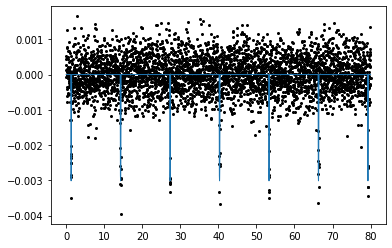

In [58]:
import matplotlib.pyplot as plt
plt.plot(t, data, ".k", ms=4, label="data")
plt.plot(t, map_soln["y"], lw=1)

In [59]:
np.random.seed(8462852)
with model:
    trace = pmx.sample(
        tune=5000,
        draws=5000,
        start=map_soln,
        cores=4,
        chains=4,
        target_accept=0.9,
    )

/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, r, us, t0, logP]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 122 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [60]:
import arviz as az

In [61]:
with model:
    summary = az.summary(trace, var_names=["period", "t0", "r", "b", "us"])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,13.000,0.001,12.999,13.001,0.000,0.000,9659.0,10893.0,1.0
t0,1.300,0.003,1.295,1.305,0.000,0.000,9587.0,11499.0,1.0
r,0.049,0.001,0.048,0.051,0.000,0.000,2366.0,580.0,1.0
b,0.143,0.093,0.000,0.302,0.002,0.002,1623.0,643.0,1.0
us[0],0.461,0.242,0.003,0.848,0.003,0.002,4543.0,4339.0,1.0
us[1],0.272,0.347,-0.370,0.848,0.005,0.004,4882.0,5072.0,1.0


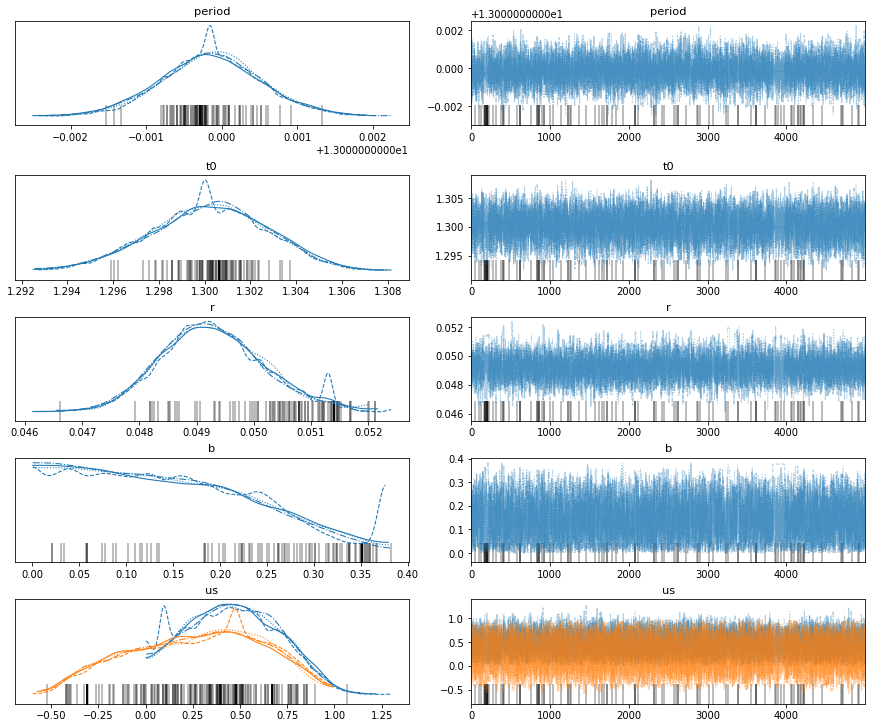

In [62]:
with model:
    az.plot_trace(trace, var_names=["period", "t0", "r", "b", "us"]);

In [63]:
with model:
    print(pm.summary(trace))

/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/ar

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
logP      2.565  0.000   2.565    2.565      0.000    0.000    9659.0   
t0        1.300  0.003   1.295    1.305      0.000    0.000    9587.0   
period   13.000  0.001  12.999   13.001      0.000    0.000    9659.0   
us[0]     0.461  0.242   0.003    0.848      0.003    0.002    4543.0   
us[1]     0.272  0.347  -0.370    0.848      0.005    0.004    4882.0   
...         ...    ...     ...      ...        ...      ...       ...   
y[3995]   0.000  0.000   0.000    0.000      0.000    0.000   20000.0   
y[3996]   0.000  0.000   0.000    0.000      0.000    0.000   20000.0   
y[3997]   0.000  0.000   0.000    0.000      0.000    0.000   20000.0   
y[3998]   0.000  0.000   0.000    0.000      0.000    0.000   20000.0   
y[3999]   0.000  0.000   0.000    0.000      0.000    0.000   20000.0   

         ess_tail  r_hat  
logP      10893.0    1.0  
t0        11499.0    1.0  
period    10893.0    1.0  
us[0]      4339

In [64]:
import corner

/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


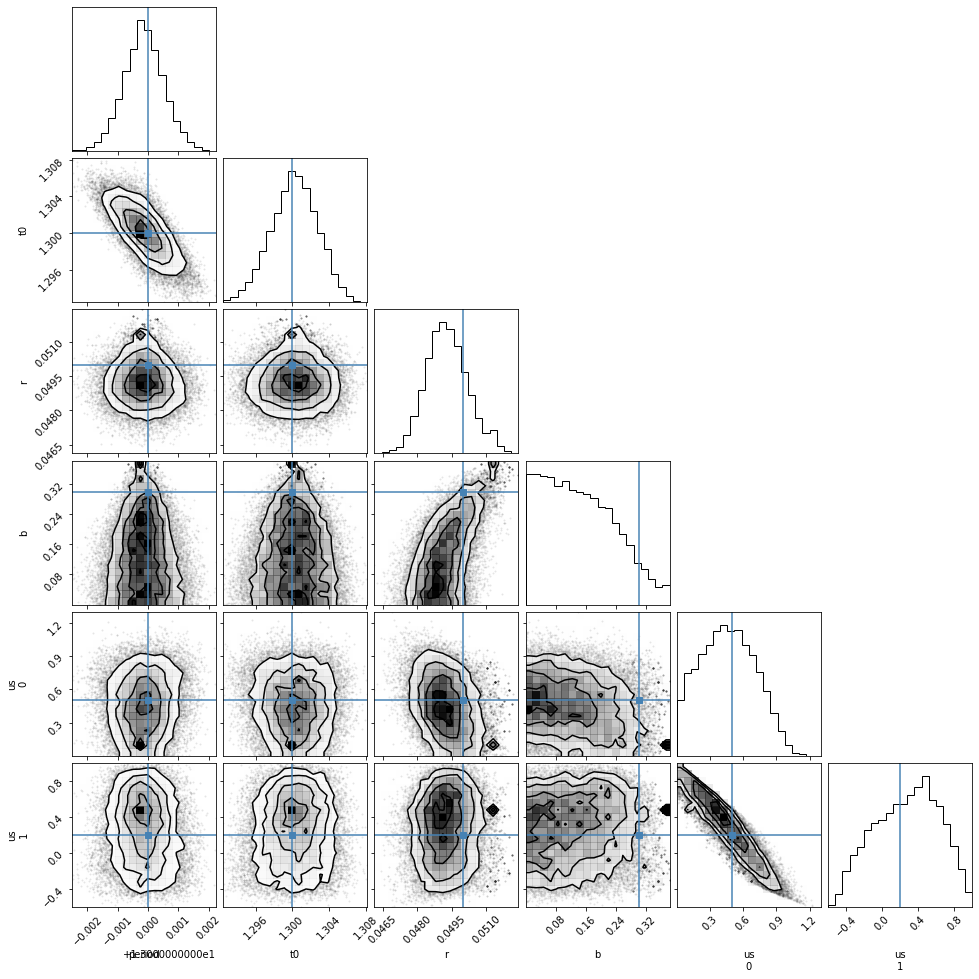

In [65]:
truth = dict(
    zip(
        ["period", "t0", "r", "b", "us"],
        xo.eval_in_model([period, t0, r, b, us], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["period", "t0", "r", "b", "us"],
    truths=truth,
)

In [66]:
np.savetxt("../data/exoplanet_gen.dat", np.stack([t, data], axis=1))

In [67]:
truth

{'period': array(13.),
 't0': array(1.3),
 'r': array(0.05),
 'b': array(0.3),
 'us': array([0.5, 0.2])}